In [102]:
import datetime

import pandas as pd
import spacy
import re
import string
import numpy as np

import seaborn as sns
from matplotlib import cm
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline

from spacy.tokens import Token
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import gensim
from gensim import corpora, models
from gensim.models.phrases import Phrases, Phraser
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import HdpModel

from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import itertools

import pyLDAvis.gensim
pyLDAvis.enable_notebook()
from ipywidgets import interact
pyLDAvis.enable_notebook()

import nltk
from nltk.corpus import stopwords
from textblob import TextBlob

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

import enchant
pd.set_option('display.max_rows', 500)

In [596]:
#### Importing the file ####
Path="src/"
Filename='IDBasedonSimliarity.csv'
df=pd.read_csv(Path+Filename)

ID_df=df[df['Interdiscipilinary']]

coord_df=pd.read_csv(Path+'IDSimliarityCats.csv')

In [536]:
## Word Embeddings Functions

## Generate the tagged documents (tagging based on the category column)
def create_tagged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
        yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

## Generate the tagged documents (each record in single tag )
def create_tagged_document_based_on_tags(list_of_list_of_words, tags):
    for i in range(len(list_of_list_of_words)):
        yield gensim.models.doc2vec.TaggedDocument(list_of_list_of_words[i], [tags[i]])

def make_bigram(inputlist):
    bigram = Phrases(inputlist, min_count=3, threshold=1,delimiter=b' ')
    bigram_phraser = Phraser(bigram)
    new_list=[]
    for sent in inputlist:
        new_list.append(bigram_phraser[sent])
    return new_list        
        
## Generate output using the word embedding model prediction - takes long time to regenerate
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs#.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [537]:
###############################
#### LDA Topic Functions #####
###############################

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
    return result

#def make_bigram(inputlist):
#    bigram = Phrases(inputlist, min_count=1, threshold=1,delimiter=b' ')
#    bigram_phraser = Phraser(bigram)
#    new_list=[]
#    for sent in inputlist:
#        new_list.append(bigram_phraser[sent])
#    return new_list

def buildLDA(processed_docs, ip_num_topics=4):
    dictionary = gensim.corpora.Dictionary(processed_docs)
    dictionary.filter_extremes(no_below=5, no_above=0.1, keep_n=1000)
    bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

    tfidf = models.TfidfModel(bow_corpus)
    corpus_tfidf = tfidf[bow_corpus]
    
    return dictionary,bow_corpus,corpus_tfidf#, lda_model_tfidf

def LDAtopicSummary(model, displaysubplot=[2,2]):
    for idx, topic in model.print_topics(-1):
        print('Topic: {} Word: {}'.format(idx, topic))
        
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list            
        #print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords',"Text"]
    return(sent_topics_df)

def build_topics_sentences(ldamodel, corpus):
    # Init output
    sent_topics_df = pd.DataFrame()
    out_df=[]
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel.get_document_topics(corpus)):
        row = sorted(row_list, key=lambda x: x[1], reverse=True)
        inn_df=[]
        for num,prob in row:
            inn_df.append(num)
            inn_df.append(prob)
        out_df.append(np.array(inn_df))
            
    return out_df

def build_topic_df(model, cc,ip_num_topics):
    Categories=[]
    Topic_ids=[]
    words=[]
    probs=[]

    topic_words=[]
    for i in range(ip_num_topics):
        for (word, value) in model.show_topic(i):
            Topic_ids.append(i)
            words.append(word)
            probs.append(value)
            Categories.append(cc)

    return pd.DataFrame({'Category':Categories,'Topic':Topic_ids, 'words':words,'probs':probs })

In [538]:
df['PrimaryTopic']=0
df['PT_Score']=0
df['SecondaryTopic']=0
df['ST_score']=0

topic_words=pd.DataFrame()

### TF-IDF for small datasets

In [539]:
for i,w in df.groupby('ID_Categories'):
    if((len(w)<20) or (',' not in i) ):
        vectorizer=TfidfVectorizer(max_features=10, ngram_range=(1, 1))
        review_vectors = vectorizer.fit_transform(w['PreProcessedDescription'])
        features_df = pd.DataFrame(review_vectors.toarray(), columns = vectorizer.get_feature_names())
        print(i, len(w))
        print(features_df.sum().sort_values(ascending=False))    
        
        topic_word_1=pd.DataFrame(features_df.sum().sort_values(ascending=False)).reset_index()
        topic_word_1.columns=['words','probs']
        topic_word_1['Category']=i
        topic_word_1['Topic']=0
        
        topic_words=pd.concat([topic_words,topic_word_1])

Engineering Sciences 4286
method       862.275089
datum        804.237358
use          536.144997
design       500.323326
control      493.179394
test         477.619886
problem      465.654961
structure    449.340489
task         402.951573
network      380.883022
dtype: float64
Engineering Sciences,Humanities and Social Sciences,Natural Sciences 15
material       4.532961
area           2.875631
concept        2.605906
chemical       2.531132
focus          2.379990
particle       1.963167
theoretical    1.685496
historical     1.635145
practice       1.516626
glass          0.994752
dtype: float64
Humanities and Social Sciences 8594
social        1397.427155
question      1295.649358
german        1189.443776
history       1169.449399
form          1083.741229
century       1081.663934
political      992.530328
historical     979.889265
cultural       959.150270
language       665.347896
dtype: float64
Humanities and Social Sciences,Natural Sciences 2
metal         0.868012
glass   

In [540]:
ID_cat=[]
volume=[]
numtopic=[]
coherences=[]


for cc,w in ID_df.groupby('ID_Categories'):
    if(len(w)>50):
        print(cc, len(w))    
        docs=w[(w.ID_Categories==cc)]["PreProcessedDescription"].map(preprocess)
        #print(cc, str(len(docs))+' docs in input')
        
        ipnumlist=list(range(8,12)) if (len(w)>1000) else list(range(3,9))
        
        dictionary,bow_corpus,corpus_tfidf =buildLDA(docs)
        for ip_num_topics in ipnumlist:
            lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=ip_num_topics, id2word=dictionary, passes=4, workers=4, 
                                                             eta=[0.001]*len(dictionary.keys()), alpha =.001*ip_num_topics, random_state=42)

            # Compute Coherence Score using c_v
            coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=docs, dictionary=dictionary, coherence='c_v')
            coherence_lda = coherence_model_lda.get_coherence()
            print('     Topic :',ip_num_topics ,'Coherence Score: ', coherence_lda)
            ID_cat.append(cc)
            volume.append(len(w))
            numtopic.append(ip_num_topics)
            coherences.append(coherence_lda)

Engineering Sciences,Humanities and Social Sciences 750
     Topic : 3 Coherence Score:  0.31746946359691935
     Topic : 4 Coherence Score:  0.27679470087502067
     Topic : 5 Coherence Score:  0.32085230247813035
     Topic : 6 Coherence Score:  0.3097401868719919
     Topic : 7 Coherence Score:  0.30743278077780817
     Topic : 8 Coherence Score:  0.33524679848039707
Engineering Sciences,Life Sciences 419
     Topic : 3 Coherence Score:  0.40698444253619764
     Topic : 4 Coherence Score:  0.3904255777396999
     Topic : 5 Coherence Score:  0.43055788435238795
     Topic : 6 Coherence Score:  0.43640082668737684
     Topic : 7 Coherence Score:  0.42340061325433614
     Topic : 8 Coherence Score:  0.3905571708403241
Engineering Sciences,Life Sciences,Natural Sciences 260
     Topic : 3 Coherence Score:  0.43218821690582715
     Topic : 4 Coherence Score:  0.4546894946197745
     Topic : 5 Coherence Score:  0.44043433183137315
     Topic : 6 Coherence Score:  0.4615875116439876
     T

In [541]:
#tuning=pd.DataFrame({'ID_Categories':ID_cat,'Size':volume,'NumTopic':numtopic,'Coherences':coherences })
#finaltuning=tuning[tuning.Coherences.isin(tuning.groupby('ID_Categories').max()['Coherences'])].reset_index()[tuning.columns]
finaltuning

,ID_Categories,Size,NumTopic,Coherences
0,"Engineering Sciences,Humanities and Social Sci...",750,8,0.335247
1,"Engineering Sciences,Life Sciences",419,6,0.436401
2,"Engineering Sciences,Life Sciences,Natural Sci...",260,6,0.461588
3,"Engineering Sciences,Natural Sciences",18691,11,0.560572
4,"Life Sciences,Natural Sciences",178,4,0.488384


### Engineering Sciences,Humanities and Social Sciences

In [542]:
cc=finaltuning.loc[0].ID_Categories
ip_num_topics=finaltuning.loc[0].NumTopic

print(cc,ip_num_topics)
docs=ID_df[(ID_df.ID_Categories==cc)]["PreProcessedDescription"].map(preprocess)

dictionary,bow_corpus,corpus_tfidf =buildLDA(docs)

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=ip_num_topics, id2word=dictionary, passes=4, workers=4, eta=[0.0001]*len(dictionary.keys()), alpha =.001*ip_num_topics, random_state=42)

# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('     Topic :',ip_num_topics ,'Coherence Score: ', coherence_lda)


topic_words=pd.concat([topic_words,build_topic_df(lda_model_tfidf,cc,ip_num_topics)])

topic_df=pd.DataFrame(build_topics_sentences(lda_model_tfidf,corpus_tfidf))[[0,1,2,3]]
topic_df.columns=['PrimaryTopic','PT_Score','SecondaryTopic','ST_score']

df.loc[((df['Interdiscipilinary']) & (ID_df.ID_Categories==cc)),'PrimaryTopic']=topic_df['PrimaryTopic'].tolist()
df.loc[(df['Interdiscipilinary']) & (ID_df.ID_Categories==cc),'PT_Score']=topic_df['PT_Score'].tolist()
df.loc[(df['Interdiscipilinary']) & (ID_df.ID_Categories==cc),'SecondaryTopic']=topic_df['SecondaryTopic'].tolist()
df.loc[(df['Interdiscipilinary']) & (ID_df.ID_Categories==cc),'ST_score']=topic_df['ST_score'].tolist()

Engineering Sciences,Humanities and Social Sciences 8
     Topic : 8 Coherence Score:  0.33524679848039707


/Users/balaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [543]:
#pyLDAvis.gensim.prepare(lda_model_tfidf, bow_corpus, dictionary)

In [544]:
#df_filter=df[(df['Interdiscipilinary']) & (ID_df.ID_Categories==cc)].reset_index()[['SubUrl', 'Translates']]
#topicsdf=pd.concat([df_filter,topic_df], axis=1)
#topicsdf[(topicsdf.PrimaryTopic==2) & pd.isnull(topicsdf.SecondaryTopic)].sort_values('PT_Score',ascending=False).head().Translates.tolist()

### Engineering Sciences,Life Sciences

In [545]:
cc=finaltuning.loc[1].ID_Categories
ip_num_topics=finaltuning.loc[1].NumTopic

print(cc,ip_num_topics)
docs=ID_df[(ID_df.ID_Categories==cc)]["PreProcessedDescription"].map(preprocess)

dictionary,bow_corpus,corpus_tfidf =buildLDA(docs)

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=ip_num_topics, id2word=dictionary, passes=4, workers=4, eta=[0.0001]*len(dictionary.keys()), alpha =.001*ip_num_topics, random_state=42)

# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('     Topic :',ip_num_topics ,'Coherence Score: ', coherence_lda)

topic_words=pd.concat([topic_words,build_topic_df(lda_model_tfidf,cc,ip_num_topics)])

topic_df=pd.DataFrame(build_topics_sentences(lda_model_tfidf,corpus_tfidf))[[0,1,2,3]]
topic_df.columns=['PrimaryTopic','PT_Score','SecondaryTopic','ST_score']

df.loc[((df['Interdiscipilinary']) & (ID_df.ID_Categories==cc)),'PrimaryTopic']=topic_df['PrimaryTopic'].tolist()
df.loc[(df['Interdiscipilinary']) & (ID_df.ID_Categories==cc),'PT_Score']=topic_df['PT_Score'].tolist()
df.loc[(df['Interdiscipilinary']) & (ID_df.ID_Categories==cc),'SecondaryTopic']=topic_df['SecondaryTopic'].tolist()
df.loc[(df['Interdiscipilinary']) & (ID_df.ID_Categories==cc),'ST_score']=topic_df['ST_score'].tolist()



Engineering Sciences,Life Sciences 6
     Topic : 6 Coherence Score:  0.4303902291117756


/Users/balaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


In [546]:
#lda_model_tfidf.show_topics()

In [547]:
#pyLDAvis.gensim.prepare(lda_model_tfidf, bow_corpus, dictionary)

In [548]:
#df_filter=df[(df['Interdiscipilinary']) & (ID_df.ID_Categories==cc)].reset_index()[['SubUrl', 'Translates']]
#topicsdf=pd.concat([df_filter,topic_df], axis=1)
#topicsdf[(topicsdf.PrimaryTopic==1) & pd.isnull(topicsdf.SecondaryTopic)].sort_values('PT_Score',ascending=False).head().Translates.tolist()

### Engineering Sciences,Life Sciences,Natural Sciences

In [549]:
cc=finaltuning.loc[2].ID_Categories
ip_num_topics=finaltuning.loc[2].NumTopic

print(cc,ip_num_topics)
docs=ID_df[(ID_df.ID_Categories==cc)]["PreProcessedDescription"].map(preprocess)

dictionary,bow_corpus,corpus_tfidf =buildLDA(docs)

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=ip_num_topics, id2word=dictionary, passes=4, workers=4, eta=[0.0001]*len(dictionary.keys()), alpha =.001*ip_num_topics, random_state=42)

# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('     Topic :',ip_num_topics ,'Coherence Score: ', coherence_lda)

topic_words=pd.concat([topic_words,build_topic_df(lda_model_tfidf,cc,ip_num_topics)])

topic_df=pd.DataFrame(build_topics_sentences(lda_model_tfidf,corpus_tfidf))[[0,1,2,3]]
topic_df.columns=['PrimaryTopic','PT_Score','SecondaryTopic','ST_score']

df.loc[((df['Interdiscipilinary']) & (ID_df.ID_Categories==cc)),'PrimaryTopic']=topic_df['PrimaryTopic'].tolist()
df.loc[(df['Interdiscipilinary']) & (ID_df.ID_Categories==cc),'PT_Score']=topic_df['PT_Score'].tolist()
df.loc[(df['Interdiscipilinary']) & (ID_df.ID_Categories==cc),'SecondaryTopic']=topic_df['SecondaryTopic'].tolist()
df.loc[(df['Interdiscipilinary']) & (ID_df.ID_Categories==cc),'ST_score']=topic_df['ST_score'].tolist()



Engineering Sciences,Life Sciences,Natural Sciences 6
     Topic : 6 Coherence Score:  0.4608165481687448


/Users/balaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


In [550]:
#lda_model_tfidf.show_topics()

In [551]:
#pyLDAvis.gensim.prepare(lda_model_tfidf, bow_corpus, dictionary)

### Engineering Sciences,Natural Sciences

In [552]:
cc=finaltuning.loc[3].ID_Categories
ip_num_topics=finaltuning.loc[3].NumTopic

print(cc,ip_num_topics)
docs=ID_df[(ID_df.ID_Categories==cc)]["PreProcessedDescription"].map(preprocess)

dictionary,bow_corpus,corpus_tfidf =buildLDA(docs)

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=ip_num_topics, id2word=dictionary, passes=4, workers=4, eta=[0.0001]*len(dictionary.keys()), alpha =.001*ip_num_topics, random_state=42)

# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('     Topic :',ip_num_topics ,'Coherence Score: ', coherence_lda)

topic_words=pd.concat([topic_words,build_topic_df(lda_model_tfidf,cc,ip_num_topics)])

topic_df=pd.DataFrame(build_topics_sentences(lda_model_tfidf,corpus_tfidf))[[0,1,2,3]]
topic_df.columns=['PrimaryTopic','PT_Score','SecondaryTopic','ST_score']

df.loc[((df['Interdiscipilinary']) & (ID_df.ID_Categories==cc)),'PrimaryTopic']=topic_df['PrimaryTopic'].tolist()
df.loc[(df['Interdiscipilinary']) & (ID_df.ID_Categories==cc),'PT_Score']=topic_df['PT_Score'].tolist()
df.loc[(df['Interdiscipilinary']) & (ID_df.ID_Categories==cc),'SecondaryTopic']=topic_df['SecondaryTopic'].tolist()
df.loc[(df['Interdiscipilinary']) & (ID_df.ID_Categories==cc),'ST_score']=topic_df['ST_score'].tolist()



Engineering Sciences,Natural Sciences 11
     Topic : 11 Coherence Score:  0.5434713436649325


/Users/balaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


In [553]:
#lda_model_tfidf.show_topics()

In [554]:
#pyLDAvis.gensim.prepare(lda_model_tfidf, bow_corpus, dictionary)

### Life Sciences,Natural Sciences

In [555]:
cc=finaltuning.loc[4].ID_Categories
ip_num_topics=finaltuning.loc[4].NumTopic

print(cc,ip_num_topics)
docs=ID_df[(ID_df.ID_Categories==cc)]["PreProcessedDescription"].map(preprocess)

dictionary,bow_corpus,corpus_tfidf =buildLDA(docs)

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=ip_num_topics, id2word=dictionary, passes=4, workers=4, eta=[0.0001]*len(dictionary.keys()), alpha =.001*ip_num_topics, random_state=42)

# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('     Topic :',ip_num_topics ,'Coherence Score: ', coherence_lda)

topic_words=pd.concat([topic_words,build_topic_df(lda_model_tfidf,cc,ip_num_topics)])

topic_df=pd.DataFrame(build_topics_sentences(lda_model_tfidf,corpus_tfidf))[[0,1,2,3]]
topic_df.columns=['PrimaryTopic','PT_Score','SecondaryTopic','ST_score']

df.loc[((df['Interdiscipilinary']) & (ID_df.ID_Categories==cc)),'PrimaryTopic']=topic_df['PrimaryTopic'].tolist()
df.loc[(df['Interdiscipilinary']) & (ID_df.ID_Categories==cc),'PT_Score']=topic_df['PT_Score'].tolist()
df.loc[(df['Interdiscipilinary']) & (ID_df.ID_Categories==cc),'SecondaryTopic']=topic_df['SecondaryTopic'].tolist()
df.loc[(df['Interdiscipilinary']) & (ID_df.ID_Categories==cc),'ST_score']=topic_df['ST_score'].tolist()



Life Sciences,Natural Sciences 4
     Topic : 4 Coherence Score:  0.48838384849015726


/Users/balaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


In [556]:
#lda_model_tfidf.show_topics()

In [557]:
#pyLDAvis.gensim.prepare(lda_model_tfidf, bow_corpus, dictionary)

### Word Embedding - data generation

In [558]:
DescDictforpca=[[x for x in str(i).split()] for i in df.PreProcessedDescription]

tagged_valueforpca = list(create_tagged_document(DescDictforpca))

modelforpca = gensim.models.doc2vec.Doc2Vec(vector_size=10, min_count=5, epochs=40, alpha = 0.02, dm=1, workers=4)

# Build the Volabulary
modelforpca.build_vocab(tagged_valueforpca)
modelforpca.train(tagged_valueforpca, total_examples=len(tagged_valueforpca), epochs=40)

new_features=pd.concat([pd.DataFrame(modelforpca.docvecs.vectors_docs),df[['PrimaryTopic', 'PT_Score', 'SecondaryTopic', 'ST_score']]], axis=1,ignore_index=False)
cols=new_features.columns

### LDA Visualization for Topics

In [559]:
topic_words=topic_words.drop_duplicates()#
topic_words.Category.value_counts()

Engineering Sciences,Natural Sciences                                   110
Engineering Sciences,Humanities and Social Sciences                      80
Engineering Sciences,Life Sciences                                       60
Engineering Sciences,Life Sciences,Natural Sciences                      60
Life Sciences,Natural Sciences                                           40
Engineering Sciences,Humanities and Social Sciences,Natural Sciences     10
Life Sciences                                                            10
Natural Sciences                                                         10
Humanities and Social Sciences                                           10
Engineering Sciences                                                     10
Humanities and Social Sciences,Natural Sciences                          10
Name: Category, dtype: int64

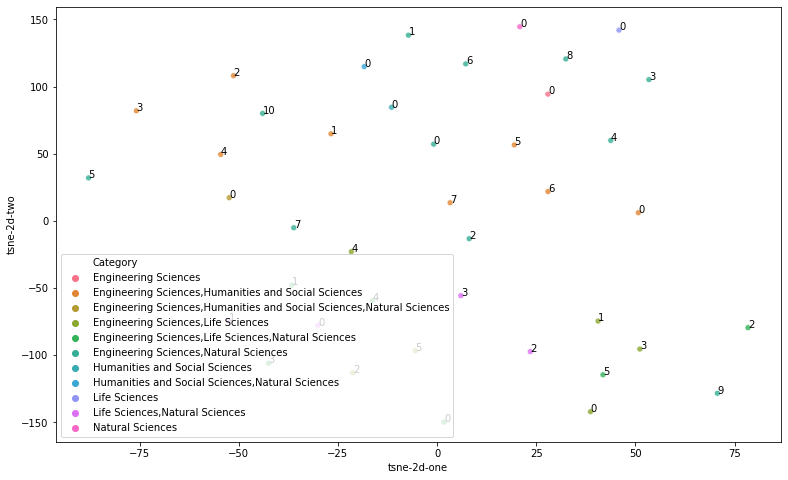

In [608]:
#topic_words[topic_words.Category=='Engineering Sciences,Humanities and Social Sciences']#.words.tolist()
topic_feature_c=[]
topic_feature_t=[]
topic_feature_w=[]

for (c,t), w in topic_words.groupby(['Category','Topic']):
    topic_feature_c.append(c)
    topic_feature_t.append(t)
    topic_feature_w.append(w.words.tolist())
    
topic_features=[]
for t in topic_feature_w:
    topic_features.append(modelforpca.infer_vector(t))
topic_features=pd.DataFrame(topic_features)
topic_features['Category']=topic_feature_c
topic_features['Topic']=topic_feature_t
topic_features['words']=[' '.join(w) for w in topic_feature_w]

topic_features['tsne-2d-one']=0
topic_features['tsne-2d-two']=0

coords= TSNE(n_components=2,perplexity=16, random_state=42, n_iter=450).fit_transform(topic_features[range(10)])
topic_features.loc[:, 'tsne-2d-one']=pd.DataFrame(coords)[0].tolist()
topic_features.loc[:, 'tsne-2d-two']=pd.DataFrame(coords)[1].tolist()

i='Engineering Sciences,Humanities and Social Sciences,Natural Sciences'
plt.figure(figsize=(13,8))
p1=sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="Category",
        data=topic_features,
        #legend="full",
        #palette="Set2",
        alpha=0.8
    );

for line in range(coords.shape[0]):
     p1.text(coords[line][0]+0.03, coords[line][1], topic_features.Topic[line], horizontalalignment='left',  size='medium', color='black')

In [678]:
## Redistribute from 0 to 1
for c,w in topic_words.groupby(['Category']):
    if(w['probs'].max()>1):
        topic_words.loc[topic_words.Category==c,['probs']]=MinMaxScaler([0,1]).fit_transform(topic_words[topic_words.Category==c][['probs']])

In [681]:
topic_words[topic_words.Category=='Engineering Sciences']

,Category,Topic,probs,words
0,Engineering Sciences,0,1.000000,method
1,Engineering Sciences,0,0.879438,datum
2,Engineering Sciences,0,0.322527,use
3,Engineering Sciences,0,0.248114,design
4,Engineering Sciences,0,0.233274,control
5,Engineering Sciences,0,0.200952,test
6,Engineering Sciences,0,0.176097,problem
7,Engineering Sciences,0,0.142207,structure
8,Engineering Sciences,0,0.045843,task
9,Engineering Sciences,0,0.000000,network


In [679]:
topic_words.to_csv(Path+'IDSimliarityTopicWords.csv', index=False)
topic_features[['Category', 'Topic','words', 'tsne-2d-one', 'tsne-2d-two']].to_csv(Path+'IDSimliarityTopic.csv', index=False)

### LDA Visualization for DF

In [562]:
df.loc[pd.isnull(df.SecondaryTopic),'SecondaryTopic']=-1
df.loc[pd.isnull(df.ST_score),'ST_score']=-1

In [563]:
dfWE=pd.DataFrame(modelforpca.docvecs.vectors_docs)
dfWE['ID_Categories']=df['ID_Categories']
#dfWE['PrimaryTopic']=df['PrimaryTopic']

dfWE[['PrimaryTopic', 'PT_Score', 'SecondaryTopic', 'ST_score']]=df[['PrimaryTopic', 'PT_Score', 'SecondaryTopic', 'ST_score']]

In [564]:
dfWE['ID_Categories'].value_counts()
perp={}
for i,w in dfWE.groupby('ID_Categories'):
    perp[i]=len(w)
print(perp)
perp={'Engineering Sciences': 100,
 'Engineering Sciences,Humanities and Social Sciences': 3.5,
 'Engineering Sciences,Humanities and Social Sciences,Natural Sciences': 3.5,
 'Engineering Sciences,Life Sciences': 3.5,
 'Engineering Sciences,Life Sciences,Natural Sciences': 3.5,
 'Engineering Sciences,Natural Sciences': 100,
 'Humanities and Social Sciences': 70,
 'Humanities and Social Sciences,Natural Sciences': 3,
 'Life Sciences': 100,
 'Life Sciences,Natural Sciences': 10,
 'Natural Sciences': 30}

{'Engineering Sciences': 4286, 'Engineering Sciences,Humanities and Social Sciences': 750, 'Engineering Sciences,Humanities and Social Sciences,Natural Sciences': 15, 'Engineering Sciences,Life Sciences': 419, 'Engineering Sciences,Life Sciences,Natural Sciences': 260, 'Engineering Sciences,Natural Sciences': 18691, 'Humanities and Social Sciences': 8594, 'Humanities and Social Sciences,Natural Sciences': 2, 'Life Sciences': 13017, 'Life Sciences,Natural Sciences': 178, 'Natural Sciences': 1448}


In [565]:
df['tsne-2d-one']=0
df['tsne-2d-two']=0
i='Life Sciences,Natural Sciences'

for c, w in dfWE.groupby('ID_Categories'):
    print(c,len(w),perp[c])
    coords = TSNE(n_components=2,perplexity=perp[c], random_state=42, n_iter=650).fit_transform(dfWE[dfWE.ID_Categories==c][['PrimaryTopic', 'PT_Score', 'SecondaryTopic', 'ST_score']+list(range(3))])
    df.loc[dfWE.ID_Categories==c, 'tsne-2d-one']=pd.DataFrame(coords)[0].tolist()
    df.loc[dfWE.ID_Categories==c, 'tsne-2d-two']=pd.DataFrame(coords)[1].tolist()

Engineering Sciences 4286 100
Engineering Sciences,Humanities and Social Sciences 750 3.5
Engineering Sciences,Humanities and Social Sciences,Natural Sciences 15 3.5
Engineering Sciences,Life Sciences 419 3.5
Engineering Sciences,Life Sciences,Natural Sciences 260 3.5
Engineering Sciences,Natural Sciences 18691 100
Humanities and Social Sciences 8594 70
Humanities and Social Sciences,Natural Sciences 2 3
Life Sciences 13017 100
Life Sciences,Natural Sciences 178 10
Natural Sciences 1448 30


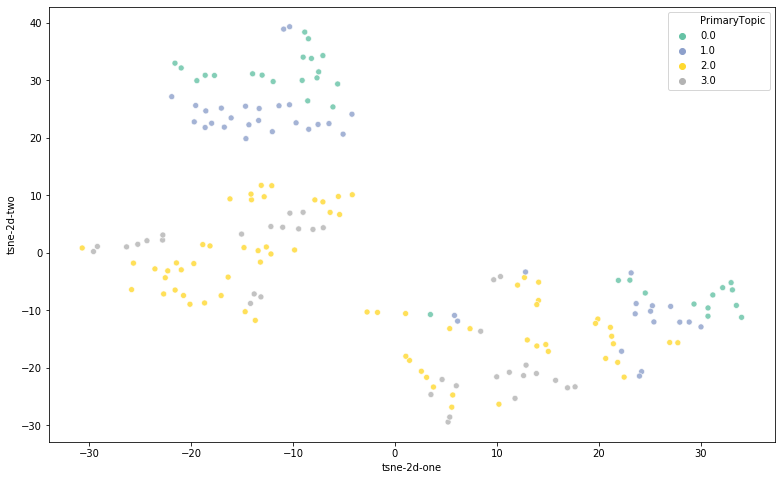

In [566]:
plt.figure(figsize=(13,8))
sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="PrimaryTopic",
        data=df[df.ID_Categories==i],
        legend="full",
        palette="Set2",
        alpha=0.8
    );

In [588]:
df=df[pd.isnull(df['ID_Categories'])==False]

In [590]:
#df[df['Interdiscipilinary']==False].groupby(['Category','ID_Categories']).count()['SubUrl']

In [609]:
df.PrimaryTopic=df.PrimaryTopic.astype(int)
#topic_features.Topic=topic_features.Topic.astype(int)
df.to_csv(Path+'FinalSimiliarID.csv', index=False)

In [610]:
df.columns

Index(['Name', 'SubUrl', 'FundingFrom', 'FundingEnd', 'SubjectArea',
       'Institution', 'Description', 'Translates', 'Name_Translated',
       'PreProcessedDescription', 'File_Categories', 'Category',
       'PrimaryMatching', 'PrimaryMatchingSim', 'SecMatching',
       'SecMatchingSim', 'ThrdMatching', 'ThrdMatchingSim', 'ID_Categories',
       'Interdiscipilinary', 'PrimaryTopic', 'PT_Score', 'SecondaryTopic',
       'ST_score', 'tsne-2d-one', 'tsne-2d-two'],
      dtype='object')

In [611]:
report_df=df.merge(topic_features[['Category', 'Topic','words', 'tsne-2d-one', 'tsne-2d-two']],
        how='left',
        left_on=['ID_Categories','PrimaryTopic'],
        right_on=['Category', 'Topic'],
        suffixes=('', '_CatTopic')
        )

In [612]:
coord_df.columns=['ID_Categories','tsne-2d-one', 'tsne-2d-two','volume','SecMatching',
       'SecMatchingSim', 'ThrdMatching', 'ThrdMatchingSim', ]

In [613]:
Finalreport_df=report_df.merge(coord_df, how='left', left_on='ID_Categories', right_on='ID_Categories',suffixes=('', '_Cat'))

In [618]:
Finalreport_df=Finalreport_df.drop(['Description', 'Translates', 'Name_Translated',
       'PreProcessedDescription'], axis=1)

In [619]:
Finalreport_df.to_csv(Path+'FinalReportSimiliarID.csv', index=False)

In [621]:
Finalreport_df.columns

Index(['Name', 'SubUrl', 'FundingFrom', 'FundingEnd', 'SubjectArea',
       'Institution', 'File_Categories', 'Category', 'PrimaryMatching',
       'PrimaryMatchingSim', 'SecMatching', 'SecMatchingSim', 'ThrdMatching',
       'ThrdMatchingSim', 'ID_Categories', 'Interdiscipilinary',
       'PrimaryTopic', 'PT_Score', 'SecondaryTopic', 'ST_score', 'tsne-2d-one',
       'tsne-2d-two', 'Category_CatTopic', 'Topic', 'words',
       'tsne-2d-one_CatTopic', 'tsne-2d-two_CatTopic', 'tsne-2d-one_Cat',
       'tsne-2d-two_Cat', 'volume'],
      dtype='object')

In [676]:
for c,w in topic_wordstest.groupby(['Category']):
    if(w['probs'].max()>1):
        topic_wordstest.loc[topic_words.Category==c,['probs']]=MinMaxScaler([0,1]).fit_transform(topic_wordstest[topic_wordstest.Category==c][['probs']])